"""
An example to demonstrate online control of lorenz system

Authors: 
Hao Zhang

References:
Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta.
"Online dynamic mode decomposition for time-varying systems."
SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.

Created:
June 2017.
"""

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip list

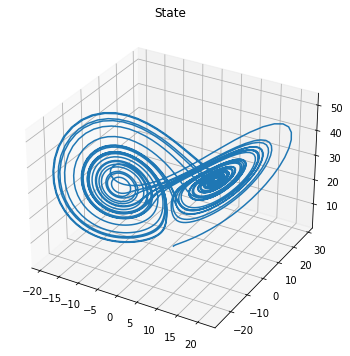

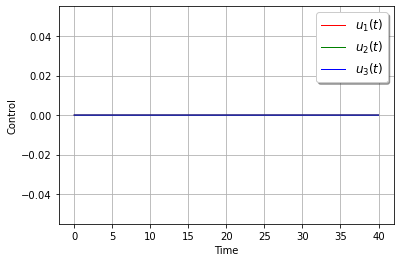

In [4]:
"""
An example to demonstrate online control of lorenz system

Authors: 
Hao Zhang

References:
Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta.
"Online dynamic mode decomposition for time-varying systems."
SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.

Created:
June 2017.
"""


import matplotlib.pyplot as plt
import numpy as np
from osysid import OnlineLinearModel
from control import lqr, StateSpace, ctrb

# define dynamics
# https://en.wikipedia.org/wiki/Lorenz_system
# Lorenz
n = 3
k = 3
sigma = 10
beta = 8.0 / 3.0
rho = 28
def dyn(x, u):
    assert x.shape == (n,)
    assert u.shape == (k,)
    f = np.zeros(n)
    f[0] = sigma * (x[1] - x[0]) + u[0]
    f[1] = x[0] * (rho - x[2]) - x[1] + u[1]
    f[2] = x[0] * x[1] - beta * x[2] + u[2]
    return f

# fixed point
phi = np.sqrt(beta * (rho - 1))
xf1 = np.array([phi, phi, rho - 1])
xf2 = np.array([-phi, -phi, rho - 1])
xf3 = np.array([0, 0, 0])

# set up simulation parameter
dt = 0.01
tmax, tc = 40, 0.2
T, kc = int(tmax / dt), int(tc / dt)
tspan = np.linspace(0, tmax, T + 1)

# online linear system identification setup
alpha = 0.01 ** (2.0 / kc)
olm = OnlineLinearModel(n, k, None, alpha)

# store data mtrices
x = np.zeros([n, T])
u = np.zeros([k, T])

# initial condition, state and control
x0 = np.array([1, 1, 1])
u0 = np.array([0, 0, 0])
x[:, 0] = x0
u[:, 0] = u0

# uncontrolled system
for t in range(1, T):
    # forward the system for one step
    x[:, t] = x[:, t - 1] + dt * dyn(x[:, t - 1], u[:, t - 1])
    u[:, t] = 0


def plot_state(x):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca(projection="3d")
    ax.plot(x[0, :], x[1, :], x[2, :])
    plt.title("State")
    plt.draw()
    # plt.grid()
    plt.show()


def plot_control(u):
    plt.figure(figsize=(6, 4))
    plt.plot(tspan[1:], u[0, :], "r-", linewidth=1.0, label="$u_1(t)$")
    plt.plot(tspan[1:], u[1, :], "g-", linewidth=1.0, label="$u_2(t)$")
    plt.plot(tspan[1:], u[2, :], "b-", linewidth=1.0, label="$u_3(t)$")
    plt.legend(loc="best", fontsize=12, shadow=True)
    plt.xlabel("Time")
    plt.ylabel("Control")
    plt.grid()
    plt.show()


# plot state and control
plot_state(x)
plot_control(u)

In [ ]:
# controlled system simulation
# we want to stabilize system at fixed point xf1
# need to shift state by -xf1

# initial condition, state and control
x[:, 0] = x0
u[:, 0] = u0

# control system simulation
for t in range(1, T):
    # forward the system for one step
    x[:, t] = x[:, t - 1] + dt * dyn(x[:, t - 1], u[:, t - 1])
    # use new measurement to update online system identification
    olm.update(x[:, t - 1] - xf1, u[:, t - 1], x[:, t] - xf1)
    # apply control if we have collected enough data
    if t > 2 * max(n, n + k):
        # convert to continuous representation
        Ac = (olm.A - np.eye(n)) / dt
        Bc = olm.B / dt
        # get LQR gain, output = state
        sys = StateSpace(Ac, Bc, np.eye(n), np.zeros((n, k)), dt=0)
        K, S, E = lqr(sys, 10 * np.eye(n), np.eye(k))
        # apply control
        u[:, t] = -1.0 * K.dot(x[:, t] - xf1)
        # clip control
        u[:, t] = np.clip(u[:, t], -10, 10)
        # smooth control
        w = 0.8
        u[:, t] = (1 - w) * u[:, t - 1] + w * u[:, t]
        # show progress
        if t % 1000 == 0:
            print(f"t={t * dt}")
            print(f"x(t)={x[:, t]}")
            print(f"u(t)={u[:, t]}")
            print(f"Ac={Ac}")
            print(f"Bc={Bc}")
            print(f"K={K}\n")
    # random small perturbation if not enough data yet
    else:
        u[:, t] = 1e-1 * np.random.randn(k)

plot_state(x)
plot_control(u)